In [1]:
import time, re
import numpy as np
import pandas as pd
import seaborn as sb
from konlpy.tag import Okt
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = 8, 5

import sklearn.metrics as m
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

#### 맛집 리뷰 데이터 읽기

In [2]:
df = pd.read_csv('data10/review_data.csv')
df.head(10)

,score,review,y
0,5,친절하시고 깔끔하고 좋았습니다,1
1,5,조용하고 고기도 굿,1
2,4,"갈비탕과 냉면, 육회비빔밥이 맛있습니다.",1
3,4,대체적으로 만족하나\n와인의 구성이 살짝 아쉬움,1
4,5,고기도 맛있고 서비스는 더 최고입니다~,1
5,5,고기가 입에서 녹아요~! 서비스도 최고였습니다.,1
6,5,입에서 살살녹는 최상급소고기를 맛보고왔습니다.,1
7,5,고기도 구워주고 가성비 짱~~<,1
8,4,콜키지 프리라서 와인을 가지고 가면 좋은 식당!\n생고기가 플레이팅도 아주 예쁘게 ...,1
9,4,저렴하면서도 맛이 아주 좋았습니다.\n구워주시는 서버분들의 정성이 고기 한점 한점에...,1


#### 한글 정제
- 한글 이외의 글자 혹은 특수문자 등은 제외.

In [3]:
# 한글 정제 함수 생성.
def text_cleaning(text) :
    # 한글 정규식.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    
    # 한글 정규식에 해당하지 않는 것은 길이가 0인 문자열로 변환.
    result = hangul.sub('', text)
    return result

In [4]:
# 리뷰 내용 정제.
df['ko_text'] = df['review'].apply(lambda x : text_cleaning(x))

# review 컬럼 제거.
del df['review']
df.head(10)

,score,y,ko_text
0,5,1,친절하시고 깔끔하고 좋았습니다
1,5,1,조용하고 고기도 굿
2,4,1,갈비탕과 냉면 육회비빔밥이 맛있습니다
3,4,1,대체적으로 만족하나와인의 구성이 살짝 아쉬움
4,5,1,고기도 맛있고 서비스는 더 최고입니다
5,5,1,고기가 입에서 녹아요 서비스도 최고였습니다
6,5,1,입에서 살살녹는 최상급소고기를 맛보고왔습니다
7,5,1,고기도 구워주고 가성비 짱
8,4,1,콜키지 프리라서 와인을 가지고 가면 좋은 식당생고기가 플레이팅도 아주 예쁘게 나오고...
9,4,1,저렴하면서도 맛이 아주 좋았습니다구워주시는 서버분들의 정성이 고기 한점 한점에 깃들...


#### 형태소 분석

In [5]:
# konlpy 라이브러리로 텍스트 데이터에서 형태소를 추출.
def get_pos(x) :
    tagger = Okt()
    pos = tagger.pos(x)
    
    # 형태소를 담을 리스트 생성.
    result = []
    
    for a in pos :
        result.append(f'{a[0]}/{a[1]}')
    return result
    
get_pos(df['ko_text'][0])

['친절하시고/Adjective', '깔끔하고/Adjective', '좋았습니다/Adjective']

#### 분류 모델의 학습 데이터로 변환

In [6]:
# from sklearn.feature_extraction.text import CountVectorizer 이용.
# 형태소를 벡터 형태의 학습 데이터셋으로 변환.
index_vectorizer = CountVectorizer(tokenizer= lambda x : get_pos(x))
x = index_vectorizer.fit_transform(df['ko_text'].tolist())

# 단어 표시.
# index_vectorizer.vocabulary_

In [7]:
print(df['ko_text'][0])
print('')
print(x[0])

친절하시고 깔끔하고 좋았습니다

  (0, 2647)	1
  (0, 428)	1
  (0, 2403)	1


#### TF-IDF로 변환

In [8]:
# 위에서 만든 형태소 벡터를 학습 데이터 벡터로 생성.
tfidf_vectorizer = TfidfTransformer()
x = tfidf_vectorizer.fit_transform(x)
print(x[0])

  (0, 2647)	0.5548708693511647
  (0, 2403)	0.48955631270748484
  (0, 428)	0.6726462183300624


#### 학습용 데이터를 생성

In [9]:
# 타겟 데이터.
y = df['y']
print(y.value_counts())

# Split Train dataset & Test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y )
print('')
print(x_train.shape)
print(x_test.shape)

1    492
0     53
Name: y, dtype: int64

(381, 3030)
(164, 3030)


#### 모델링

In [10]:
# Logit model 생성 생성. 
model_Logit =  LogisticRegression() 
param_value = { 'penalty': [ 'l1', 'l2', 'elasticnet', 'none' ],
                'C'      : np.logspace( -5, 5, 11 ),
                'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga',]
              }
grid_search_logit = GridSearchCV( model_Logit , param_grid = param_value ) 
# grid_search_logit.get_params
grid_search_logit.fit( x_train, y_train )

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_di

In [11]:
# 테스트용 데이터를 통해 예측.
y_pred = grid_search_logit.best_estimator_.predict( x_test )
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

Accuracy        : 91.0%
----------------------------------------------------------------------------------------------------------------------------------
Precision score : 91.0%
----------------------------------------------------------------------------------------------------------------------------------
Recall score    : 100.0%
----------------------------------------------------------------------------------------------------------------------------------
F1 score        : 95.0%
----------------------------------------------------------------------------------------------------------------------------------
Roc auc Socre   : 53.0%
----------------------------------------------------------------------------------------------------------------------------------


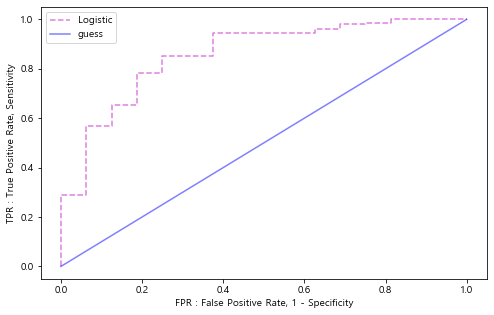

In [12]:
# Accuracy of Logit model.
print(f'Accuracy        : {round( accuracy_score(y_test, y_pred), 2)*100 }%')
print('-'*130)

# Precision of grid_search_logit.
print(f'Precision score : { round(precision_score(y_test, y_pred), 2)*100 }%' )
print('-'*130)

# Recall of grid_search_logit.
print(f'Recall score    : { round(recall_score(y_test, y_pred), 2)*100 }%' )
print('-'*130)

# F1 score of grid_search_logit.
print(f'F1 score        : { round(f1_score(y_test, y_pred), 2)*100}%' )
print('-'*130)

# Roc auc Socre of grid_search_logit.
print(f'Roc auc Socre   : { round(roc_auc_score(y_test, y_pred), 2)*100}%')
print('-'*130)

# ROC Curve
FPR, TPR, Thresholds = m.roc_curve( y_test, grid_search_logit.predict_proba( x_test )[:,1] )    
plt.plot( FPR, TPR, 'm--', label='Logistic', alpha=.5)
plt.plot( [0,1], [0,1], 'b-', label='guess' , alpha=.5)
plt.xlabel( 'FPR : False Positive Rate, 1 - Specificity' )
plt.ylabel( 'TPR : True Positive Rate, Sensitivity' )
plt.legend()
plt.show()

#### 중요 피쳐 형태소

In [13]:
# 회귀 모델의 계수를 높은 순서대로 정렬.
# 계수를 (index, 회귀계수) 형태로 형성.
a = list(enumerate(grid_search_logit.best_estimator_.coef_[0]))
# display(a)

# sorted 함수를 쓰면 첫 번째 것을 기준으로 정렬하므로 index, 계수 형태를 계수, index 형태로 바꿈.
b = list(((value, index) for index, value in a))
# b

# Sort.
coef_pos_index = sorted(b, reverse=True)
coef_pos_index[:10]

[(12.74320638880242, 721),
 (10.428581092118073, 2376),
 (9.697857257544149, 2388),
 (9.379390572508587, 2246),
 (9.050278851790821, 1030),
 (8.382583822461415, 1001),
 (7.392003507226432, 1017),
 (7.355437186238485, 1029),
 (7.23021705026837, 1600),
 (7.180576339249035, 897)]

In [14]:
# 단어 번호 : 단어 형태의 딕셔너리를 생성.
text_data_dict = {}

for text, text_id in index_vectorizer.vocabulary_.items() :
    text_data_dict[text_id] = text
# text_data_dict

In [15]:
# 긍정 단어 상위 20개.
coef_pos_index[:20]

[(12.74320638880242, 721),
 (10.428581092118073, 2376),
 (9.697857257544149, 2388),
 (9.379390572508587, 2246),
 (9.050278851790821, 1030),
 (8.382583822461415, 1001),
 (7.392003507226432, 1017),
 (7.355437186238485, 1029),
 (7.23021705026837, 1600),
 (7.180576339249035, 897),
 (7.139324100770422, 2067),
 (6.988034519123047, 608),
 (6.761857861737602, 233),
 (6.707015232512829, 2404),
 (6.6905028934375625, 2763),
 (6.461781378251048, 2077),
 (6.440604007524958, 945),
 (6.39719815648055, 2247),
 (6.347646683874718, 635),
 (6.308341342035584, 2613)]

In [16]:
# 부정 단어 상위 20개.
coef_pos_index[-20:]

[(-10.507350939027557, 1430),
 (-10.609948727226323, 1260),
 (-10.96235009214013, 2127),
 (-10.96235009214013, 354),
 (-11.023396334927035, 1156),
 (-11.720460207240123, 589),
 (-12.072627849889617, 2603),
 (-12.287846855257994, 470),
 (-12.420269854960706, 338),
 (-12.49523697302753, 2887),
 (-12.643995476996317, 2312),
 (-12.992796989101622, 2620),
 (-13.891257308196339, 1384),
 (-14.45348811391519, 2070),
 (-16.584182869599132, 2371),
 (-17.397696834504554, 2289),
 (-18.311700271661103, 2069),
 (-22.58170774450426, 1309),
 (-23.120194692336103, 399),
 (-27.743369619508183, 980)]

In [17]:
# coef_pos_index 안 있는 값들 중 단어 번호를 실제 단어로 변환.
coef_pos_text = []

for value, index in coef_pos_index :
    # index 에 해당하는 단어를 추출.
    text = text_data_dict[index]
    
    # 계수와 단어의 조합으로 만들어 담기.
    coef_pos_text.append((value, text))

# 상위 20개.
for text in coef_pos_text[:20] :
    print(text)
    
# 하위 20개.
print('-'*50)
for text in coef_pos_text[-20:] :
    print(text)

(12.74320638880242, '도/Josa')
(10.428581092118073, '좋고/Adjective')
(9.697857257544149, '좋아요/Adjective')
(9.379390572508587, '잘/Verb')
(9.050278851790821, '맛있었어요/Adjective')
(8.382583822461415, '맛있고/Adjective')
(7.392003507226432, '맛있어요/Adjective')
(7.355437186238485, '맛있었습니다/Adjective')
(7.23021705026837, '시간/Noun')
(7.180576339249035, '로/Josa')
(7.139324100770422, '으로/Josa')
(6.988034519123047, '다/Adverb')
(6.761857861737602, '고기/Noun')
(6.707015232512829, '좋았어요/Adjective')
(6.6905028934375625, '편이/Noun')
(6.461781378251048, '의/Josa')
(6.440604007524958, '만족/Noun')
(6.39719815648055, '잘/VerbPrefix')
(6.347646683874718, '다음/Noun')
(6.308341342035584, '최고/Noun')
--------------------------------------------------
(-10.507350939027557, '비해/Verb')
(-10.609948727226323, '받지/Verb')
(-10.96235009214013, '이었지만/Verb')
(-10.96235009214013, '그럭저럭/Adverb')
(-11.023396334927035, '못/VerbPrefix')
(-11.720460207240123, '는/Josa')
(-12.072627849889617, '체인점/Noun')
(-12.287846855257994, '나쁘지/Adjective')
